In [ ]:
# classify images visually

import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images from the validation generator
x, y = next(val_generator)

# Select a few images to display
num_images = 5
indices = np.random.choice(x.shape[0], num_images, replace=False)
images = x[indices]
labels = y[indices]

# Get the class labels from the generator
class_indices = {v: k for k, v in train_generator.class_indices.items()}

# Display the images with predicted labels
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
for i in range(num_images):
  axes[i].imshow(images[i])
  predicted_class = class_indices[np.argmax(labels[i])]
  axes[i].set_title(f"Predicted: {predicted_class}")
  axes[i].axis('off')

plt.show()



# Import required libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Step 1: Data Preparation
# Set path to your dataset, organized in subfolders (aphids, army_worm, bacterial_blight, etc.)
train_data_dir = '/kaggle/input/cotton-disease/train'  # Update this with the actual Kaggle dataset path
val_data_dir = '/kaggle/input/cotton-disease/test'  # Update this with the actual Kaggle dataset path

# Data augmentation to prevent overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Image data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


In [36]:
# Step 2: Model Selection - Use Transfer Learning with ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model so that the pre-trained weights are not updated
base_model.trainable = False

# Add new layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Adjust output layer based on your classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)


In [38]:
# Step 3: Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Step 4: Compute class weights based on integer labels (not one-hot encoded)
class_labels = train_generator.classes  # These are the integer labels corresponding to each image class
class_weights = compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)

# Convert class weights to a dictionary format required by Keras
class_weights_dict = dict(enumerate(class_weights))

In [39]:

# Step 5: Train the model with class weights
history = model.fit(
    train_generator,
    epochs=20,  # Adjust epochs as needed
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights_dict  # Use the dictionary of class weights here
)

# Step 6: Fine-tuning - Unfreeze some layers of ResNet50 for better accuracy
base_model.trainable = True
fine_tune_at = 100  # Unfreeze layers from index 100 onward

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training with unfrozen layers
history_fine = model.fit(
    train_generator,
    epochs=10,  # Adjust based on need
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights_dict  # Use the same class weights for fine-tuning
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


270/270 ━━━━━━━━━━━━━━━━━━━━ 131s 437ms/step - accuracy: 0.2172 - loss: 1.8707 - val_accuracy: 0.2954 - val_loss: 1.6269 - learning_rate: 0.0010
Epoch 2/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 110s 398ms/step - accuracy: 0.2782 - loss: 1.6798 - val_accuracy: 0.4078 - val_loss: 1.5265 - learning_rate: 0.0010
Epoch 3/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 113s 407ms/step - accuracy: 0.2999 - loss: 1.6562 - val_accuracy: 0.4105 - val_loss: 1.5154 - learning_rate: 0.0010
Epoch 4/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 111s 402ms/step - accuracy: 0.3354 - loss: 1.6021 - val_accuracy: 0.4008 - val_loss: 1.4560 - learning_rate: 0.0010
Epoch 5/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 109s 395ms/step - accuracy: 0.3364 - loss: 1.5737 - val_accuracy: 0.4411 - val_loss: 1.4120 - learning_rate: 0.0010
Epoch 6/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 111s 400ms/step - accuracy: 0.3423 - loss: 1.5454 - val_accuracy: 0.4438 - val_loss: 1.3440 - learning_rate: 0.0010
Epoch 7/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 110s 397ms/step - accuracy: 0.3690 

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.9685 - loss: 0.1232
Validation Accuracy: 96.81%


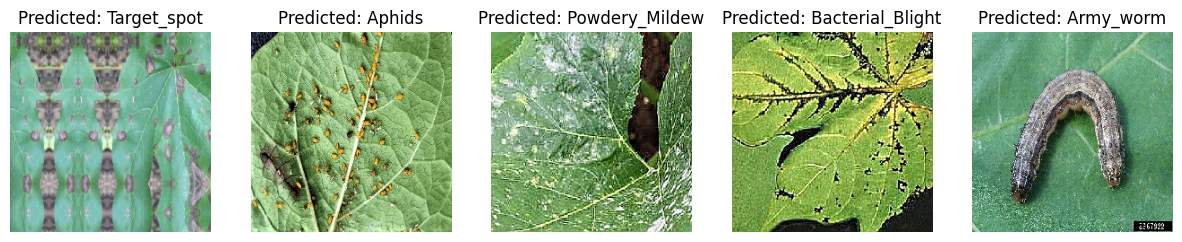

In [41]:
# Step 7: Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Step 8: Save the model for future use
model.save('crop_disease_prediction_model.h5')

# Step 9: Load the model and use it for prediction on new images
def predict_image(img_path, model, train_generator):
    img = image.load_img(img_path, target_size=(224, 224))  # Ensure the image module is correctly imported
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image

    predictions = model.predict(img_array)
    class_indices = {v: k for k, v in train_generator.class_indices.items()}  # Invert the class indices dictionary
    predicted_class = class_indices[np.argmax(predictions)]
    return predicted_class

# classify images visually

import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images from the validation generator
x, y = next(val_generator)

# Select a few images to display
num_images = 5
indices = np.random.choice(x.shape[0], num_images, replace=False)
images = x[indices]
labels = y[indices]

# Get the class labels from the generator
class_indices = {v: k for k, v in train_generator.class_indices.items()}

# Display the images with predicted labels
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
for i in range(num_images):
  axes[i].imshow(images[i])
  predicted_class = class_indices[np.argmax(labels[i])]
  axes[i].set_title(f"Predicted: {predicted_class}")
  axes[i].axis('off')

plt.show()

In [61]:
import pandas as pd

# Loading the CSV file into a DataFrame
data = pd.read_csv('/kaggle/input/pesticide-cotton/cotton_pesticide.csv')

# Displaying the first few rows
print(data.head())


            Disease                                        Description  \
0            Aphids                                   Sap-sucking pest   
1          Armyworm                Spodoptera spp,\n Leaf-chewing pest   
2  Bacterial Blight                             Xanthomonas axonopodis   
3    Powdery Mildew      Fungal disease caused by \nLeveillula taurica   
4       Target Spot  Fungal disease caused by \nCorynespora cassiicola   

    Pesticide\n (Small Region) Dosage\n(Small Region)  \
0            Dimethoate 30% EC               500ml/ha   
1          Chlorpyrifos 20% EC                  1L/ha   
2  Copper Oxychloride\n 50% WP               2.5kg/ha   
3                Sulfur 80% WP                 3kg/ha   
4              Mancozeb 75% WP                 1kg/ha   

                                               Usage  \
0   Apply as a foliar spray \nat the first sign o...   
1  Spray at the early stages \nof infestation. Re...   
2  Apply as a foliar spray at\n the first si

In [62]:
import pandas as pd

# Load the cotton pesticide dataset
try:
    cotton_data = pd.read_csv('/kaggle/input/pesticide-cotton/cotton_pesticide.csv')  # Use the file path to load the uploaded data
    print("Dataset loaded successfully!")
    print(cotton_data.head())  # Print the first few rows to inspect the data
except Exception as e:
    print(f"Error loading CSV file: {e}")

# Function to get disease information based on the predicted class
def get_disease_info(predicted_class):
    # Check if cotton_data is a valid DataFrame
    if not isinstance(cotton_data, pd.DataFrame):
        print("Error: cotton_data is not a DataFrame.")
        return

    # Ensure the predicted_class is a string and strip any extra whitespace
    predicted_class = str(predicted_class).strip().lower()

    # Extract the row corresponding to the predicted disease
    try:
        disease_info = cotton_data[cotton_data['Disease'].str.strip().str.lower() == predicted_class]
    except Exception as e:
        print(f"Error filtering disease information: {e}")
        return

    if disease_info.empty:
        print(f"No information available for this disease: {predicted_class}")
        return

    # Retrieve the pesticide recommendations and other details
    disease_description = disease_info['Description'].values[0]
    pesticide_small = disease_info['Pesticide\n (Small Region)'].values[0]
    dosage_small = disease_info['Dosage\n(Small Region)'].values[0]
    usage_small = disease_info['Usage'].values[0]

    pesticide_large = disease_info['Pesticide\n(Large Region)'].values[0]
    dosage_large = disease_info['Dosage\n(Large Region)'].values[0]
    usage_large = disease_info['Usage\n(Large Region)'].values[0]

    organic_method = disease_info['Organic Method'].values[0]
    organic_usage = disease_info['Usage\n(Organic Method)'].values[0]

    # Display the results
    print(f"Disease: {predicted_class}")
    print(f"Description: {disease_description}\n")

    print(f"Recommended Pesticide for Small Region: {pesticide_small}")
    print(f"Dosage (Small Region): {dosage_small}")
    print(f"Usage (Small Region): {usage_small}\n")

    print(f"Recommended Pesticide for Large Region: {pesticide_large}")
    print(f"Dosage (Large Region): {dosage_large}")
    print(f"Usage (Large Region): {usage_large}\n")

    print(f"Organic Methods: {organic_method}")
    print(f"Usage (Organic Methods): {organic_usage}\n")


# Example of how to call the function with error handling for debugging
def predict_and_recommend(img_path=None):
    if img_path is None:
        img_path = input("Enter the path to the image you want to test: ")

    # Predict the disease using the predict_image function
    # Placeholder since predict_image, model, and train_generator are not defined in this snippet
    # predicted_class = predict_image(img_path, model, train_generator)

    # Mock-up for testing purposes
    predicted_class = 'aphids'  # This should be replaced by the actual prediction logic

    # Get pesticide recommendations based on the predicted disease
    get_disease_info(predicted_class)

# Test the function interactively or with a hardcoded path
predict_and_recommend()  # Will prompt the user for an image path or use the hardcoded prediction                                                                                                            


Dataset loaded successfully!
            Disease                                        Description  \
0            Aphids                                   Sap-sucking pest   
1          Armyworm                Spodoptera spp,\n Leaf-chewing pest   
2  Bacterial Blight                             Xanthomonas axonopodis   
3    Powdery Mildew      Fungal disease caused by \nLeveillula taurica   
4       Target Spot  Fungal disease caused by \nCorynespora cassiicola   

    Pesticide\n (Small Region) Dosage\n(Small Region)  \
0            Dimethoate 30% EC               500ml/ha   
1          Chlorpyrifos 20% EC                  1L/ha   
2  Copper Oxychloride\n 50% WP               2.5kg/ha   
3                Sulfur 80% WP                 3kg/ha   
4              Mancozeb 75% WP                 1kg/ha   

                                               Usage  \
0   Apply as a foliar spray \nat the first sign o...   
1  Spray at the early stages \nof infestation. Re...   
2  Apply as a f

Enter the path to the image you want to test:  /kaggle/input/predictions/cotton_d1.jpg


Disease: aphids
Description: Sap-sucking pest

Recommended Pesticide for Small Region:  Dimethoate 30% EC
Dosage (Small Region): 500ml/ha
Usage (Small Region):  Apply as a foliar spray 
at the first sign of aphid
 infestation. Reapply 
every 7–10 days.

Recommended Pesticide for Large Region: Imidacloprid 17.8% SL
Dosage (Large Region):  200–250ml/ha
Usage (Large Region): Systemic insecticide 
providing longer-lasting 
control for large areas. 
Apply early to prevent
 the spread of aphids.

Organic Methods: * Use neem oil
*Use yellow sticky traps
Usage (Organic Methods): *Use neem oil (2% solution) 
or insecticidal soap as a foliar 
spray to control aphids.
*Use yellow sticky traps to capture aphids and monitor pest populations.

